In [7]:
import datetime
import urllib
import pandas as pd
import sqlalchemy as sa
import numpy as np
import matplotlib.pyplot as plt

In [21]:
upload=pd.read_csv(r"~\Desktop\Corona\data.csv")
df_covid=pd.read_csv(r"~\Desktop\Corona\df_covid.csv")
upload["Last_updated"]=pd.to_datetime(upload["Last_updated"]).dt.strftime("%Y-%m-%d")
upload.tail()
#upload.to_sql('covid19', con=engine, if_exists='append')

Location Positive_Cases Last_updated  \
853                           Wayne             27   2020-04-02   
854                     Westchester         11,567   2020-04-02   
855                         Wyoming             14   2020-04-02   
856                           Yates              1   2020-04-02   
857  Total Number of Positive Cases         92,381   2020-04-02   

    Last_updated_time  
853             16:01  
854             16:01  
855             16:01  
856             16:01  
857             16:01

In [11]:
df_covid=pd.concat([df_covid, upload])

C:\Users\Jensen\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [7]:
df_nodups=df_covid.drop_duplicates(['Location', 'Last_updated', 'Last_updated_time'], keep='first').sort_values(by='Last_updated')
df_nodups['Positive_Cases']=pd.to_numeric(df_nodups['Positive_Cases'].str.replace(",",""))
df_nodups["Location"]=df_nodups["Location"].str.strip()
df_nodups["NAME"]=df_nodups["Location"].replace({"New York City:": "New York","New York City": "New York", "Broom":"Broome", "Total Positive Cases (Statewide)": "Total Number of Positive Cases"})

df_nodups.to_csv(r"~\Desktop\Corona\df_covid_clean.csv")

import plotly.express as px

fig = px.line(df_nodups, x="Last_updated", y="Positive_Cases", color='NAME')
fig.show()

In [8]:
pivoted=pd.pivot_table(df_nodups.filter(items=['NAME','Last_updated','Positive_Cases']),
               index='NAME',
               columns='Last_updated',
               values="Positive_Cases",
              fill_value=0)
#df of all Counties including NYC and cumulative positive cases by day
df=pd.DataFrame(pivoted.to_records())
df_nodups=df_nodups.drop(columns=['Scrape_Time'])

In [9]:
#json for all US counties
import json
import geopandas as gpd
with open(r'C:\Users\Jensen\Desktop\Corona\gz_2010_us_050_00_500k.json') as f:
  data = json.load(f)
#json to str format? geojson for NY?
test=json.dumps(data)
#geojson into geopandas subset?
geo_us_counties=gpd.read_file(test)
#narrow down to new york
ny=geo_us_counties[geo_us_counties["STATE"]=='36']
ny.crs= {'init': 'epsg:4326'}

In [ ]:
# Create a function the returns json_data for the year selected by the user
def json_data(selectedDate):
    yr = selectedDate
    
    # Pull selected year from neighborhood summary data
    df_date = df_nodups[df_nodups['Last_updated'] == selectedDate]
    
    # Merge the GeoDataframe object (sf) with the neighborhood summary data (neighborhood)
#merged = 
    merged=pd.merge(ny, df_date, on='NAME', how='left')
    
    # Fill the null values
    #values = {'Date': yr, 'sale_price_count': 0, 'sale_price_mean': 0, 'sale_price_median': 0,
    #          'sf_mean': 0, 'price_sf_mean': 0, 'min_income': 0}
    #merged = merged.fillna(value=values)
    
    # Bokeh uses geojson formatting, representing geographical features, with json
    # Convert to json
    merged_json = json.loads(merged.to_json())
    
    # Convert to json preferred string-like object 
    json_data = json.dumps(merged_json)
    return json_data

In [14]:
import pandas as pd
import numpy as np
import math

import geopandas
import json

from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter
from bokeh.palettes import brewer

from bokeh.io.doc import curdoc
from bokeh.models import Slider, HoverTool, Select
from bokeh.layouts import widgetbox, row, column
# Input geojson source that contains features for plotting for:
# initial year 2018 and initial criteria sale_price_median
geosource = GeoJSONDataSource(geojson = json_data("2020-04-01"))
input_field = 'Positive_Cases'

# Define a sequential multi-hue color palette.
palette = brewer['Blues'][3]

# Reverse color order so that dark blue is highest
palette = palette[::-1]

# Add hover tool
hover = HoverTool(tooltips = [ ('County','@NAME'),
                             ('Positive Cases', '@Positive_Cases')])

# Call the plotting function
p = make_plot(input_field)

# Make a slider object: slider 
#slider = Slider(title = 'Year',start ="2020-03-14" , end = "2020-03-24", step = 1, value ="2020-03-14")
#slider.on_change('value', update_plot)

# Make a selection object: select
#select = Select(title='Select Criteria:', value='Median Sales Price', options=['Median Sales Price', 'Minimum Income Required',
                                                                              # 'Average Sales Price', 'Average Price Per Square Foot',
                                                                               #'Average Square Footage', 'Number of Sales'])
#select.on_change('value', update_plot)

# Make a column layout of widgetbox(slider) and plot, and add it to the current document
# Display the current document
layout = column(p)
curdoc().add_root(layout)
output_notebook()

Loading BokehJS ...

In [31]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import Arrow
import datetime

def excel_date(date1):
    temp = datetime.datetime(1899, 12, 30)    # Note, not 31st Dec but 30th!
    delta = datetime.datetime.strptime(date1, '%Y-%m-%d') - temp
    return float(delta.days) + (float(delta.seconds) / 86400)

43968.0

In [15]:
show(p)

In [17]:
# join the geodataframe with the df for NY positive cases
merged = ny.set_index("NAME").join(df.set_index("NAME"))

In [34]:
merged_json = json.loads(merged.to_json())
json_data=json.dumps(merged_json)

In [35]:
import json

from bokeh.io import output_file, show
from bokeh.models import GeoJSONDataSource
from bokeh.plotting import figure
from bokeh.sampledata.sample_geojson import geojson

output_file("geojson.html")

data = json.loads(json_data)
for i in range(len(data['features'])):
    data['features'][i]['properties']['Color'] = ['blue', 'red'][i%2]

geo_source = GeoJSONDataSource(geojson=json.dumps(data))

TOOLTIPS = [
    ('Organisation', '@OrganisationName')
]

p = figure(background_fill_color="lightgrey", tooltips=TOOLTIPS)
p.circle(x='x', y='y', size=15, color='Color', alpha=0.7, source=geo_source)

show(p)

In [23]:
show(p)

In [19]:
import sys
print(sys.version)
import bokeh
print(bokeh.__version__)

3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
2.0.0


C:\Users\Jensen\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning:

invalid value encountered in less



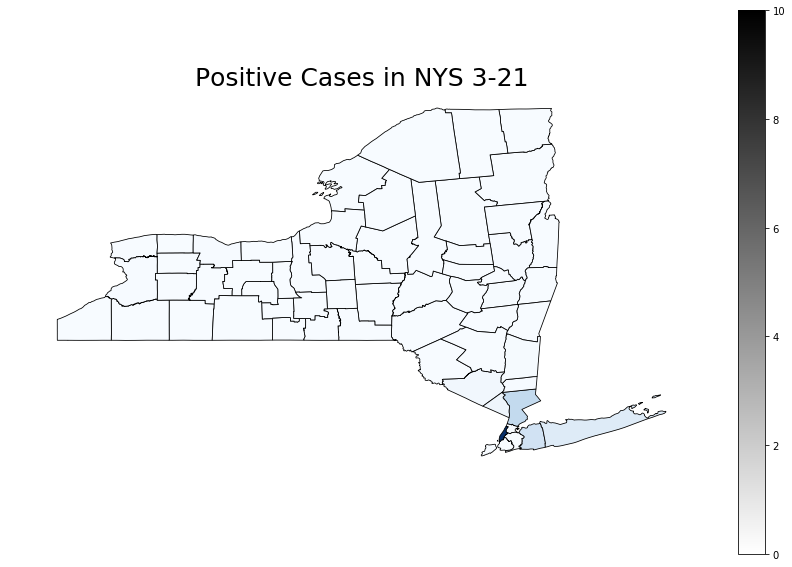

In [18]:
#Attempts at matplotlib map creation.

# set a variable that will call whatever column we want to visualise on the map
variable = "2020-03-24"
# set the range for the choropleth
vmin, vmax = 0.0, 10.0
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 10))
# create map
merged.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="k")
# remove the axis
ax.axis("off")
# add a title
ax.set_title("Positive Cases in NYS 3-21", fontdict={"fontsize": "25", "fontweight" : "3"})
# create an annotation for the data source
#ax.annotate("Source: NYS Gov, 2020",xy=(0.1, .08),  xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", fontsize=12, color="#555555")
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="binary", norm=plt.Normalize(vmin=vmin, vmax=vmax))
#empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

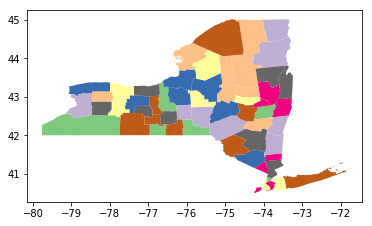

In [54]:
ax = ny.plot(column='NAME', cmap='Accent')

In [57]:
import mplleaflet
# File path


# 1.Plot data:
ny.plot()

# 2. Convert plot to a web map:

mplleaflet.show()

# 1. Plot data:
ax = ny.plot(markersize = 50, color = "red")

# 2. Convert plot to a web map:
mplleaflet.display(fig=ax.figure, crs=ny.crs)